<a href="https://colab.research.google.com/github/pjs726/MRIAccelerationNN/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In this section, we load the data and needed packages into our Colab environment. We begin by importing and installing needed packages:

In [ ]:
!pip install fastmri

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.8 MB/s eta 0:00:00
  Created wheel for runstats: filename=runstats-2.0.0-py3-none-any.whl size=12357 sha256=bab32dd9ec65cb0519ffe7241521e5b0b32ae0991005e1d66719b7281486a7c0
  Stored in directory: /root/.cache/pip/wheels/ab/f0/e7/de015

In [ ]:
import fastmri
from fastmri.data import transforms as fastMRITransforms
import os
from matplotlib import pyplot as plt
from google.colab import drive
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils import data
from torch.utils.data import DataLoader

from skimage.metrics import structural_similarity


# Data Loading

We also load our raw data (stored as a collection of npy files on my Google Drive) into the Colab environment.

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


We load each dataset from its own directory. The single-coil knee MRI data comes from a total of 60 patients, and is split into a 47/6/7

In [ ]:
trainingDataDir = os.scandir('/content/gdrive/MyDrive/UCSF/slices/training')
testDataDir =  os.scandir('/content/gdrive/MyDrive/UCSF/slices/test')
valDataDir =  os.scandir('/content/gdrive/MyDrive/UCSF/slices/val')

We now create lists comprised of NumPy arrays which are the k-spaces for every dataset.

In [ ]:
# trainingArraySet = []
# for trSliceFile in trainingDataDir:
#   trSlice = np.load(trSliceFile, mmap_mode='r+', allow_pickle=True)
#   trainingArraySet.append(trSlice)

testArraySet = []
for trSliceFile in testDataDir:
  trSlice = np.load(trSliceFile, mmap_mode='r+', allow_pickle=True)
  testArraySet.append(trSlice)

# valArraySet = []
# for trSliceFile in valDataDir:
#   trSlice = np.load(trSliceFile, mmap_mode='r+', allow_pickle=True)
#   valArraySet.append(trSlice)

# print(len(trainingArraySet))
# print(len(testArraySet))
# print(len(valArraySet))

# Part I: SGD to Determine Minimal Sampling Trajectory

Here, we define the loss function used to evaluate the model. What this loss model does is that it takes in the selectively-sampled k-space and the original k-space, and then perform's fastmri's SSIM loss function on them. It takes that and adds a term which seeks to minimize *W*, the weight matrix which in our project represents the sampled k-space lines.

In [ ]:
def loss_fn(W, underSampledKSpaceT, fullKSpace, ssim_weight=1, sampling_weight=1):

  # Determine how many rows of k-space were sampled
  #W = torch.where(W > 0.5, torch.ones_like(W), torch.zeros_like(W))
  num_rows = torch.sum(W)
  #print(W)
  underSamplingRatio = (num_rows/640) * sampling_weight

  # Convert to images and calculate SSIM
  underSampledKSpace = underSampledKSpaceT.detach().numpy()
  undersampled_tensor = fastMRITransforms.to_tensor(underSampledKSpace)
  undersampled_image = fastmri.ifft2c(undersampled_tensor)
  undersampled_image_abs = fastmri.complex_abs(undersampled_image)
  undersampled_image_abs = np.float32(undersampled_image_abs)
  undersampled_image_abs = undersampled_image_abs / np.max(undersampled_image_abs)


  full_tensor = fastMRITransforms.to_tensor(fullKSpace)
  full_image = fastmri.ifft2c(full_tensor)
  full_image_abs = fastmri.complex_abs(full_image)
  full_image_abs = np.float32(full_image_abs)
  full_image_abs = full_image_abs / np.max(full_image_abs)

  #print(full_image_abs)
  ssim = structural_similarity(undersampled_image_abs, full_image_abs)
  print(underSamplingRatio)
  print(ssim)
  ssim_loss = (1 - ssim) * ssim_weight

  # t_mask_polished = torch.where(W > 0.5, torch.ones_like(W), torch.zeros_like(W))
  # print(t_mask_polished)

  return ssim_loss + underSamplingRatio

And to aid in our visualization of data, we include an image generation function.

In [ ]:
  def imageGen(underSampledKSpaceT, fullKSpace):
    # Convert to images and calculate SSIM
    underSampledKSpace = underSampledKSpaceT.detach().numpy()
    undersampled_tensor = fastMRITransforms.to_tensor(underSampledKSpace)
    undersampled_image = fastmri.ifft2c(undersampled_tensor)
    undersampled_image_abs = fastmri.complex_abs(undersampled_image)
    undersampled_image_abs = np.float32(undersampled_image_abs)
    undersampled_image_abs = undersampled_image_abs / np.max(undersampled_image_abs)

    #print(undersampled_image_abs)
    plt.figure()
    plt.imshow(undersampled_image_abs)
    plt.figure()
    full_tensor = fastMRITransforms.to_tensor(fullKSpace)
    full_image = fastmri.ifft2c(full_tensor)
    full_image_abs = fastmri.complex_abs(full_image)
    full_image_abs = np.float32(full_image_abs)
    full_image_abs = full_image_abs / np.max(full_image_abs)
    #print(full_image_abs)
    #plt.imshow(full_image_abs)

    ssim = structural_similarity(undersampled_image_abs, full_image_abs)
    print(ssim)

We write a masking function. This mask will be applied to the fully-sampled data by the model to generate our output, undersampled k-space data.

In [ ]:
#def gen_Mask

Our strategy now is to employ a linear neural network which seeks to fit the following expression.


> *y* = A*x*

Where *y* is the output



In [ ]:
class samplingModel(nn.Module):
    def __init__(self):
        super(samplingModel, self).__init__()
        # Define your model layers, including the masking layer
        self.weight_mask = nn.Parameter(torch.rand(640, 1), requires_grad=True)
        self.masking_layer = nn.Linear(640, 1)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass through your model, including the mask
        weighted_matrix = torch.where(self.weight_mask > 0.5,
                                    torch.ones_like(self.weight_mask), torch.zeros_like(self.weight_mask))
        #print(weight_matrix)
        weighted_input = x * weighted_matrix # Element-wise multiplication
        #print(weighted_input)
        return weighted_input, self.weight_mask
sampling_model = samplingModel()

We now go about training the model.

In [ ]:
optimizer = optim.SGD(sampling_model.parameters(), lr=0.005)

losses = []
lossesVal = []
for epoch in range(11):
  epochlosses = []
  for tr_data in trainingArraySet:
    tr_data_tensor = torch.from_numpy(tr_data)
    output_tensor = torch.zeros(tr_data_tensor.shape, dtype=torch.cfloat)
    output_mask = torch.ones(640, 1)


    optimizer.zero_grad()

    output_tensor, output_mask = sampling_model(tr_data_tensor)

    loss = loss_fn(output_mask, output_tensor, tr_data, ssim_weight=3)
    #print(output_mask)
    # Backpropagation
    loss.backward()

    # Constrain the weight matrix
    optimizer.step()

    # Print loss or other metrics if desired
    epochlosses.append(loss.item())
  losses.append(np.mean(epochlosses))


  for data in valArraySet:
    lossesValList = []
    pred = torch.from_numpy(data)
    output_tensor, output_mask = sampling_model(pred)
    loss = loss_fn(output_mask, output_tensor, pred, ssim_weight=3)
    lossesValList.append(loss.detach().numpy())
  lossesVal.append(np.sum(lossesValList)/len(lossesValList))

NameError: ignored

We graph the training and validation loss.

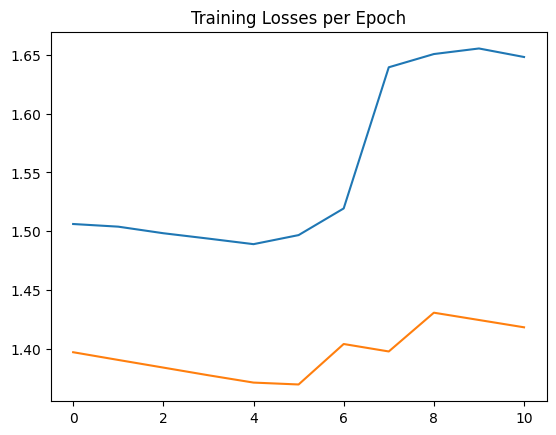

In [ ]:
plt.figure()
plt.title("Training Losses per Epoch")
plt.plot(losses)
plt.plot(lossesVal)


We now run this model on the test set and collect information on the loss.

tensor(0.4306, grad_fn=<MulBackward0>)
0.7971153581180064
tensor(0.4306, grad_fn=<MulBackward0>)
0.7515948975211875
tensor(0.4306, grad_fn=<MulBackward0>)
0.7348998171185578
tensor(0.4306, grad_fn=<MulBackward0>)
0.7139373840155478
tensor(0.4306, grad_fn=<MulBackward0>)
0.6731154048888682
tensor(0.4306, grad_fn=<MulBackward0>)
0.6330497978248903
tensor(0.4306, grad_fn=<MulBackward0>)
0.6262940717385107
tensor(0.4306, grad_fn=<MulBackward0>)
0.6052503993596958
tensor(0.4306, grad_fn=<MulBackward0>)
0.5833158151950605
tensor(0.4306, grad_fn=<MulBackward0>)
0.5888499483966193
tensor(0.4306, grad_fn=<MulBackward0>)
0.5766871748157397
tensor(0.4306, grad_fn=<MulBackward0>)
0.558094792047481
tensor(0.4306, grad_fn=<MulBackward0>)
0.5468885371917294
tensor(0.4306, grad_fn=<MulBackward0>)
0.54121261570515
tensor(0.4306, grad_fn=<MulBackward0>)
0.539183993825945
tensor(0.4306, grad_fn=<MulBackward0>)
0.5514178723456671
tensor(0.4306, grad_fn=<MulBackward0>)
0.5697190154468331
tensor(0.4306, gra

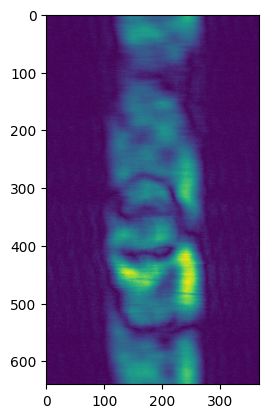

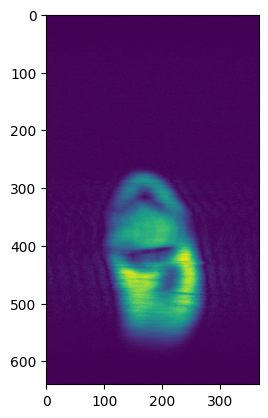

In [ ]:
losses = []
for data in testArraySet:
  pred = torch.from_numpy(data)
  output_tensor, output_mask = sampling_model(pred)
  loss = loss_fn(output_mask, output_tensor, pred, ssim_weight=3)
  losses.append(loss.detach().numpy())
print(losses)
print("Mean Test Loss: " + str(np.sum(losses)/len(losses)))



In [ ]:
torch.save(sampling_model, '/content/gdrive/MyDrive/UCSF/sampling_model')

In [ ]:
mask = np.array([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])

266.0

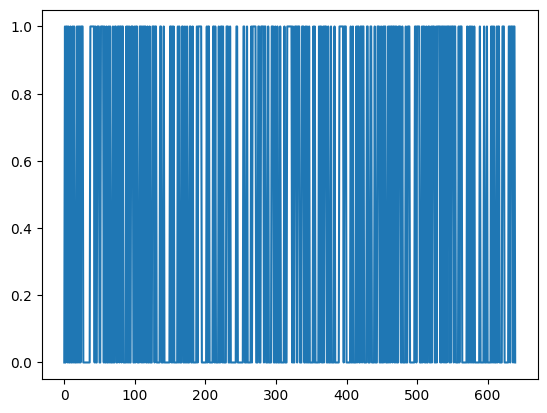

In [ ]:
plt.plot(mask)
np.sum(mask.flatten())
#len(mask)

In [ ]:
ssimList = []
for slice in testArraySet:
  undersampledSlice = mask * slice
  ssimList.append(ssimGen(undersampledSlice, slice))

In [ ]:
  def ssimGen(underSampledKSpace, fullKSpace):
    # Convert to images and calculate SSIM
    #underSampledKSpace = underSampledKSpaceT.detach().numpy()
    undersampled_tensor = fastMRITransforms.to_tensor(underSampledKSpace)
    undersampled_image = fastmri.ifft2c(undersampled_tensor)
    undersampled_image_abs = fastmri.complex_abs(undersampled_image)
    undersampled_image_abs = np.float32(undersampled_image_abs)
    undersampled_image_abs = undersampled_image_abs / np.max(undersampled_image_abs)

    #print(undersampled_image_abs)
    plt.figure()
    plt.imshow(undersampled_image_abs)
    plt.figure()
    full_tensor = fastMRITransforms.to_tensor(fullKSpace)
    full_image = fastmri.ifft2c(full_tensor)
    full_image_abs = fastmri.complex_abs(full_image)
    full_image_abs = np.float32(full_image_abs)
    full_image_abs = full_image_abs / np.max(full_image_abs)
    print(full_image_abs)
    plt.imshow(full_image_abs)

    ssim = structural_similarity(undersampled_image_abs, full_image_abs)
    return ssim

0.8119225815333021
0.045547534928228245


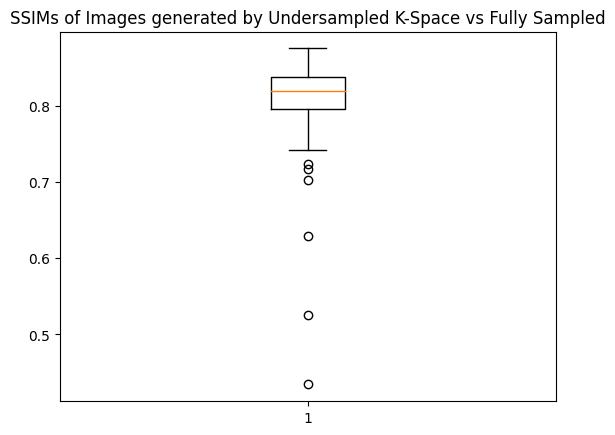

In [ ]:
ssimList
plt.boxplot(ssimList)
plt.title("SSIMs of Images generated by Undersampled K-Space vs Fully Sampled")
print(np.sum(ssimList)/len(ssimList))
import statistics
print(statistics.pstdev(ssimList))

In [ ]:
slice = testArraySet[26]
under = mask * slice
